In [168]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import sqlite3 as sql

In [107]:
cell_phones_data = pd.read_csv("cell_phones_cleaned.csv")
pop_data = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv")
country_data = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")
country_data

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


To deal with the missing values, the cells with missing values have been filled with zeroes in this task. 

In [102]:
pop_cols = pop_data.columns[1:]
def replace_nans(row, col):
    previous_value = None
    for i in range(len(col)):
        if pd.isna(row[pop_cols[i]]):
            if previous_value is None:
                row[pop_cols[i]] = 0
            else:
                row[pop_cols[i]] = previous_value
        else:
            previous_value = row[pop_cols[i]] 
    return row
    
valid_iso3_codes = [country.alpha_3 for country in pycountry.countries]
valid_pop = pop_data[pop_data['iso-3'].isin(valid_iso3_codes)]
valid_pop_fill = valid_pop.apply(lambda row: replace_nans(row, pop_cols), axis = 1)
valid_pop_fill.to_csv("valid_pop_fill.csv", index = False)

# Creating columns for population data and cell phone data
cell_phone_data = cell_phones_data.copy()
valid_pop_data = valid_pop_fill.copy()
# Melt the data: Keep 'iso-3' as identifiers, and convert year columns into rows
pop_long = pd.melt(
    valid_pop_data,
    id_vars=["iso-3"],  # Columns to keep
    var_name="Year",              # Name for the variable column (years)
    value_name="Population"       # Name for the values (populations)
)

cell_phone_long = pd.melt(
    cell_phone_data,
    id_vars=["iso-3"],  # Columns to keep
    var_name="Year",              # Name for the variable column (years)
    value_name="n_cellphones"       # Name for the values (populations)
)




merged_data = pd.merge(cell_phone_long, pop_long, on=["iso-3", "Year"], how="inner")
merged_data


,iso-3,Year,n_cellphones,Population
0,ABW,1960,0.0,54608.0
1,AFG,1960,0.0,8622466.0
2,AGO,1960,0.0,5357195.0
3,ALB,1960,0.0,1608800.0
4,AND,1960,0.0,9443.0
...,...,...,...,...
11923,WSM,2019,124000.0,211905.0
11924,YEM,2019,15300000.0,31546691.0
11925,ZAF,2019,97000000.0,58087055.0
11926,ZMB,2019,17200000.0,18380477.0


In [138]:
# Merge country data with cell phone and population data
country_data_long = pd.melt(
    country_data,
    id_vars=["alpha-3", "name"],  # Replace with the column name that identifies attributes (e.g., "Year")
    var_name="variable",     # Country names become a column
    value_name="value"      # Values corresponding to the attributes
)
merged_with_country = pd.merge(merged_data, country_data_long, left_on=["iso-3"], right_on = ["alpha-3"], how="inner")

# Ensuring numerical values

merged_with_country["Population"] = pd.to_numeric(merged_with_country["Population"], errors="coerce")
merged_with_country["Year"] = pd.to_numeric(merged_with_country["Year"], errors="coerce")
merged_with_country["n_cellphones"] = pd.to_numeric(merged_with_country["n_cellphones"], errors="coerce")

# Calculate phones per capita 

merged_with_country["phones_per_capita"] = merged_with_country["n_cellphones"] / merged_with_country["Population"]

# Filter for 2015–2019 data
filtered_data = merged_with_country[(merged_with_country["Year"] >= 2015) & (merged_with_country["Year"] <= 2019)]

top_countries_avg = (filtered_data.groupby("name")["phones_per_capita"].mean().sort_values(ascending=False).head(5).index.tolist())

# Filter data for the top 5 countries
top_countries_data = filtered_data[filtered_data["name"].isin(top_countries_avg)]

# Pivot to create the desired table
pivot_table = top_countries_data.pivot_table(
    index="Year",  # Years as rows
    columns="name",  # Top countries as columns
    values="phones_per_capita"  # Phones per capita as values
)

# Reorder columns based on 2019 values
pivot_table = pivot_table.loc[:, pivot_table.loc[2019].sort_values(ascending=False).index]

# Display the final table
print(pivot_table)

name     Macao  Hong Kong  United Arab Emirates  Antigua and Barbuda    Kuwait
Year                                                                          
2015  3.088231   2.290401              2.007424             1.956838  1.959709
2016  3.143510   2.398931              2.212521             1.987545  1.892253
2017  3.210102   2.488773              2.183431             2.019337  1.730949
2018  3.348741   2.670209              2.199084             2.008164  1.644590
2019  3.284849   2.863650              2.127739             1.997460  1.650492


<Figure size 1000x600 with 0 Axes>

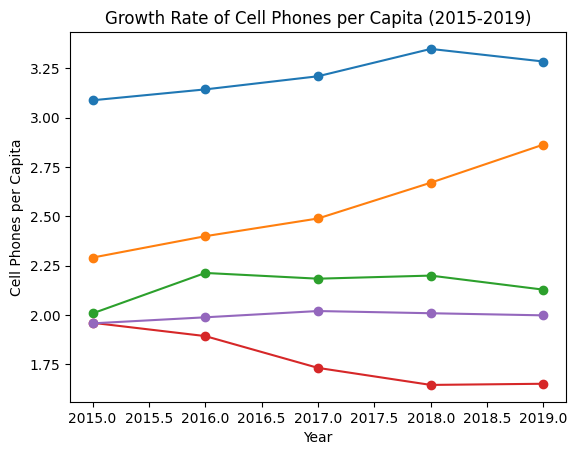

<Figure size 1000x600 with 0 Axes>

In [167]:
filtered_years = [2015, 2016, 2017, 2018, 2019] # Filter out years that are not present in the data
filtered_columns = [col for col in pivot_table.index if col in filtered_years] # Filter out years that are not present in the data
filtered_df = pivot_table.loc[filtered_columns].copy() # Make a copy to avoid SettingWithCopyWarning
top_5_countries_2015 = filtered_df.loc[2015].nlargest(5) # Get the top 5 countries in 2015
for country in top_5_countries_2015.index:
    plt.plot(filtered_df.index, filtered_df[country], marker='o', label=country)
plt.title('Growth Rate of Cell Phones per Capita (2015-2019)')
plt.xlabel('Year')
plt.ylabel('Cell Phones per Capita')
plt.figure(figsize=(10, 6))


In [181]:
# Connect to the SQLite database
conn = sql.connect('user_actions.db')

# Query to list all tables
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, conn)

print("Tables in the database:", tables)

# Check the structure of the user_actions table
columns_query = "PRAGMA table_info(user_actions);"
columns = pd.read_sql(columns_query, conn)

print("Columns in user_actions table:", columns)

# Query to load the first few rows from the user_actions table
sample_data_query = "SELECT * FROM user_actions LIMIT 5;"
sample_data = pd.read_sql(sample_data_query, conn)

print("Sample data from user_actions table:")
print(sample_data)

# Close the connection to the database
conn.close()

Tables in the database:            name
0  user_actions
Columns in user_actions table:    cid       name     type  notnull dflt_value  pk
0    0    user_id  INTEGER        0       None   0
1    1   username     TEXT        0       None   0
2    2      email     TEXT        0       None   0
3    3     action     TEXT        0       None   0
4    4  timestamp     TEXT        0       None   0
Sample data from user_actions table:
   user_id username             email          action            timestamp
0       34   user34  user34@email.com          signup  2015-02-04 14:38:47
1       28   user28  user28@email.com          signup  2015-03-09 11:55:33
2       27   user27  user27@email.com           login  2015-04-17 14:48:31
3       27   user27  user27@email.com           login  2015-04-21 13:22:14
4       27   user27  user27@email.com  reset_password  2015-04-25 16:30:15


Question: Retrieve the usernames of all the users who have performed the signup action.

In [183]:
# Connect to the SQLite database
conn = sql.connect('user_actions.db')

# Query to retrieve usernames of users who performed the "signup" action
signup_query = """
SELECT DISTINCT username 
FROM user_actions 
WHERE action = 'signup';
"""

signup_users = pd.read_sql(signup_query, conn)

# Display the result
print("Users who have performed the 'signup' action:")
print(signup_users)

# Close the connection to the database
conn.close()


Users who have performed the 'signup' action:
   username
0    user34
1    user28
2     user1
3    user24
4    user15
5    user20
6    user18
7    user25
8     user3
9     user9
10   user27
11   user16
12   user17
13    user4
14    user8
15   user13
16   user19
17   user31
18   user10
19   user23
20   user11
21   user33
22   user12
23   user29
24   user21
25    user6
26   user14
27   user30
28    user7
29   user26
30   user22
31    user5
32   user35
33    user2
34   user32


Question: Find the total number of log entries for each user. Display the user_id, username, and the count of log entries.

In [184]:
# Connect to the SQLite database
conn = sql.connect('user_actions.db')

# Query to count the total number of log entries for each user
log_entries_query = """
SELECT user_id, username, COUNT(*) AS log_entries_count
FROM user_actions
GROUP BY user_id, username;
"""

log_entries = pd.read_sql(log_entries_query, conn)

# Display the result
print("Total number of log entries for each user:")
print(log_entries)

# Close the connection to the database
conn.close()

Total number of log entries for each user:
    user_id username  log_entries_count
0         1    user1                104
1         2    user2                149
2         3    user3                108
3         4    user4                436
4         5    user5                192
5         6    user6                457
6         7    user7                362
7         8    user8                329
8         9    user9                118
9        10   user10                170
10       11   user11                328
11       12   user12                209
12       13   user13                470
13       14   user14                320
14       15   user15                 35
15       16   user16                379
16       17   user17                367
17       18   user18                122
18       19   user19                 58
19       20   user20                362
20       21   user21                323
21       22   user22                275
22       23   user23                3

Question: Identify users who have both logged in (action = 'login') and signed up (action = 'signup') on the same day. Display the user_id and username.

In [192]:
conn = sql.connect('user_actions.db')

# Update the query to use the correct column (e.g., 'action_time' instead of 'created_at')
login_signup_same_day_query = """
SELECT DISTINCT a.user_id, a.username
FROM user_actions a
JOIN user_actions b
  ON a.user_id = b.user_id
  AND date(a.timestamp) = date(b.timestamp)  -- Use the actual date column
WHERE a.action = 'login'
  AND b.action = 'signup';
"""

login_signup_same_day = pd.read_sql(login_signup_same_day_query, conn)

# Display the result
print("Users who have both logged in and signed up on the same day:")
print(login_signup_same_day)

# Close the connection to the database
conn.close()

Users who have both logged in and signed up on the same day:
   user_id username
0        8    user8
1       12   user12
2       30   user30
3        7    user7
4       22   user22
5        5    user5
6        2    user2
7       32   user32


Regex

Question : Write a regular expression to extract all hashtags from a given comment. For example, applying the regex to comment 1 should return "programming","tips".

In [194]:
import re

# Define the input and output file paths
comments = 'comments.txt'   # Path to your input file containing comments

hashtag_regex = r'#\w+'

# Function to extract hashtags from a specific comment (given by its line number)
def extract_hashtags(file_path, comment_number):
    with open(file_path, 'r') as file:
        comments = file.readlines()
        comment = comments[comment_number - 1].strip()  # Get the comment
        hashtags = re.findall(hashtag_regex, comment)  # Find all hashtags
        return hashtags

# Example usage
hashtags = extract_hashtags(comments, 1)  # Extract hashtags from comment 1
print(hashtags)

['#programming', '#tips']


Question: Create a regular expression to find comments that mention both "#programming" and "#python". Apply the regex to comment 2 and check if it matches.


In [195]:
regex = r'(?=.*#programming)(?=.*#python)'
comment_2 = "Enjoyed the article. #coding #python"

# Check if the comment matches the regex
match = re.search(regex, comment_2)

if match:
    print("Comment 2 mentions both #programming and #python.")
else:
    print("Comment 2 does not mention both #programming and #python.")

Comment 2 does not mention both #programming and #python.
